# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Load libraries

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

### Follow these steps to download and pickle the notMNIST dataset 
#### Not necessary if you already have the notMNIST.pickle file from Tensorflow Udacity example

Helper functions to download notMNIST files, extract, and pickle

In [2]:
import sys
import tar

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels          

def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

In [3]:
pickle_file = 'notMNIST.pickle'

def download_extract_pickle(file):
    if os.path.isfile(os.getcwd()+'/'+file):
        print(file, "already exists")
    else:
        url = 'http://commondatastorage.googleapis.com/books1000/'
        last_percent_reported = None
        train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
        test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)
        train_folders = maybe_extract(train_filename)
        test_folders = maybe_extract(test_filename)
        image_size = 28  # Pixel width and height.
        pixel_depth = 255.0  # Number of levels per pixel.
        num_classes = 10
        np.random.seed(133)
        train_datasets = maybe_pickle(train_folders, 45000)
        test_datasets = maybe_pickle(test_folders, 1800)
        train_size = 200000
        valid_size = 10000
        test_size = 10000

        valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
          train_datasets, train_size, valid_size)
        _, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

        print('Training:', train_dataset.shape, train_labels.shape)
        print('Validation:', valid_dataset.shape, valid_labels.shape)
        print('Testing:', test_dataset.shape, test_labels.shape)
        
        train_dataset, train_labels = randomize(train_dataset, train_labels)
        test_dataset, test_labels = randomize(test_dataset, test_labels)
        valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)
        
        try:
            f = open(pickle_file, 'wb')
            save = {
                'train_dataset': train_dataset,
                'train_labels': train_labels,
                'valid_dataset': valid_dataset,
                'valid_labels': valid_labels,
                'test_dataset': test_dataset,
                'test_labels': test_labels,
                }
            pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
            f.close()
        except Exception as e:
            print('Unable to save data to', pickle_file, ':', e)
            raise

        statinfo = os.stat(pickle_file)
        print('Compressed pickle size:', statinfo.st_size)

download_extract_pickle(pickle_file)

notMNIST.pickle already exists


### Implementation
Start here if you already have the notMNIST.pickle file

In [2]:
from random import randint
pickle_file = 'notMNIST.pickle'

def generate_sequence(dataset, labels):
    rand_index = randint(0, len(dataset)-1)
    new_data = dataset[rand_index]
    new_labels = [labels[rand_index]]
    zero = np.zeros((28,28))
    num_sequence = randint(1,4)
    for i in range(4):
        if i < num_sequence:
            rand_index = randint(0, len(dataset)-1)
            rand_letter = dataset[rand_index]
            rand_label = [labels[rand_index]]
            new_labels = np.concatenate((new_labels,rand_label), axis=0)
            new_data = np.append(new_data, rand_letter, axis=1)
        else:
            new_labels = np.concatenate((new_labels,[10]), axis=0)
            new_data = np.append(new_data, zero, axis=1)

    return new_data, new_labels

def synthetic_dataset(size, size2, size3):
    try:
        with open(pickle_file, 'rb') as f:
            save = pickle.load(f)
            train_dataset = save['train_dataset'][0:size]
            train_labels = save['train_labels'][0:size]
            valid_dataset = save['valid_dataset'][0:size2]
            valid_labels = save['valid_labels'][0:size2]
            test_dataset = save['test_dataset'][0:size3]
            test_labels = save['test_labels'][0:size3]            
            del save  # hint to help gc free up memory
    except Exception as e:
        print('Unable to load data', pickle_file, ':', e)
        raise
    
    train_x, train_y, valid_x, valid_y, test_x, test_y = [], [], [], [], [], []
    
    for _ in range(size):
        new_x,new_y = generate_sequence(train_dataset, train_labels) 
        train_x.append(new_x)
        train_y.append(new_y)
        
    for _ in range(size2):
        new_x,new_y = generate_sequence(valid_dataset, valid_labels) 
        valid_x.append(new_x)
        valid_y.append(new_y)
        
    for _ in range(size3):
        new_x,new_y = generate_sequence(test_dataset, test_labels) 
        test_x.append(new_x)
        test_y.append(new_y)
    
    del train_dataset  
    del train_labels
    del valid_dataset
    del valid_labels
    del test_dataset
    del test_labels
    
    return np.array(train_x), np.array(train_y), np.array(valid_x), np.array(valid_y), np.array(test_x), np.array(test_y)

train_data, train_labels, valid_dataset, valid_labels, test_dataset, test_labels = synthetic_dataset(20000, 2000, 2000)
print('Generate synthetic data complete')

Generate synthetic data complete


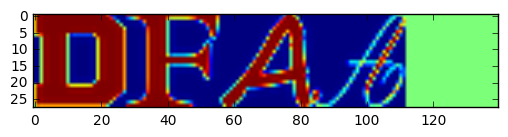

D
F
A
A
None


In [3]:
plt.imshow(train_data[1])
plt.show()
letter_labels= ['A','B','C','D','E','F','G','H','I','J','None']
for i in train_labels[1]:
    print(letter_labels[i])

In [4]:
image_height = 28
image_length = 140
num_labels = 11
num_channels = 1 # grayscale

def one_hot(l):
    return (np.arange(num_labels) == l[:,None]).astype(np.float32)
    
def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_height, image_length, num_channels)).astype(np.float32)
  one_hot_labels = [one_hot(labels[0])]
  for i in range(1, len(labels)):
    one_hot_labels= np.concatenate((one_hot_labels,[one_hot(labels[i])]), axis=0)
  return dataset, one_hot_labels

train_x, train_y = reformat(train_data, train_labels)
del train_data
del train_labels
valid_x, valid_y = reformat(valid_dataset, valid_labels)
del valid_dataset
del valid_labels
test_x, test_y = reformat(test_dataset, test_labels)
del test_dataset
del test_labels
print('Training set', train_x.shape, train_y.shape)
print('Training set', valid_x.shape, valid_y.shape)
print('Training set', test_x.shape, test_y.shape)

Training set (20000, 28, 140, 1) (20000, 5, 11)
Training set (2000, 28, 140, 1) (2000, 5, 11)
Training set (2000, 28, 140, 1) (2000, 5, 11)


In [103]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
predict_length = 6

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_height, image_length, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, predict_length))
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_height // 4 * image_length // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, predict_length], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[predict_length]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    output = tf.matmul(hidden, layer4_weights) + layer4_biases
    return output
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)


Tensor("add_3:0", shape=(16, 6), dtype=float32)
Tensor("Placeholder_1:0", shape=(16, 6), dtype=float32)


In [40]:
def one(n):
    return (np.arange(6) == n).astype(np.float32)

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

length = np.array([one(np.sum(np.sum(l, axis=1),axis=0)) for l in labels])
print(length[0], length.shape)
del length

[ 0.  0.  0.  1.  0.  0.] (20000, 6)


In [121]:
num_steps = 101

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized predict length')
  for step in range(num_steps):
    offset = (step * batch_size) % (labels.shape[0] - batch_size)
    batch_data = train[offset:(offset + batch_size), :, :, :]
    batch_labels = labels[offset:(offset + batch_size), :]
    batch_length = np.array([one(np.sum(np.sum(l, axis=1), axis=0)) for l in batch_labels])
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_length}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 10 == 0):
      #print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_length))

Initialized predict length
3
Minibatch accuracy: 100.0%
8
Minibatch accuracy: 100.0%
4
Minibatch accuracy: 100.0%
8
Minibatch accuracy: 100.0%
14
Minibatch accuracy: 100.0%
16
Minibatch accuracy: 100.0%
16
Minibatch accuracy: 100.0%
16
Minibatch accuracy: 100.0%
16
Minibatch accuracy: 100.0%
16
Minibatch accuracy: 100.0%
16
Minibatch accuracy: 100.0%


In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
num_labels = 11
eval_batch_size = 100

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_height, image_length, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, 5, num_labels))

  tf_valid_dataset = tf.placeholder(
    tf.float32, shape=(eval_batch_size, image_height, image_length, num_channels))
  tf_test_dataset = tf.placeholder(
    tf.float32, shape=(eval_batch_size, image_height, image_length, num_channels))

  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_height // 4 * image_length // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))

  classifier1_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  classifier1_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  classifier2_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  classifier2_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  classifier3_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  classifier3_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  classifier4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  classifier4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  classifier5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  classifier5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    output1 = tf.matmul(hidden, classifier1_weights) + classifier1_biases
    output2 = tf.matmul(hidden, classifier2_weights) + classifier2_biases
    output3 = tf.matmul(hidden, classifier3_weights) + classifier3_biases
    output4 = tf.matmul(hidden, classifier4_weights) + classifier4_biases
    output5 = tf.matmul(hidden, classifier5_weights) + classifier5_biases
    return [output1,output2,output3,output4,output5]

  def calc_loss(labels, logits):
     return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
         labels=labels, logits=logits))   

  
  # Training computation.
  logits1,logits2,logits3,logits4,logits5 = model(tf_train_dataset) 

  loss = calc_loss(tf_train_labels[:,0],logits1) + calc_loss(tf_train_labels[:,1],logits2) + calc_loss(
      tf_train_labels[:,2],logits3) + calc_loss(tf_train_labels[:,3],logits4) + calc_loss(tf_train_labels[:,4],logits5)
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_1, train_2, train_3, train_4, train_5 = tf.nn.softmax(
      logits1), tf.nn.softmax(logits2), tf.nn.softmax(logits3), tf.nn.softmax(logits4), tf.nn.softmax(logits5)
  train_predictions = [train_1, train_2, train_3, train_4, train_5]

  v1, v2, v3, v4, v5 = model(tf_valid_dataset)
  valid_1, valid_2, valid_3, valid_4, valid_5 = tf.nn.softmax(
      v1), tf.nn.softmax(v2), tf.nn.softmax(v3), tf.nn.softmax(v4), tf.nn.softmax(v5)
  valid_predictions = [valid_1, valid_2, valid_3, valid_4, valid_5]
  
  t1, t2, t3, t4, t5 = model(tf_test_dataset)
  test_1, test_2, test_3, test_4, test_5 = tf.nn.softmax(
      t1), tf.nn.softmax(t2), tf.nn.softmax(t3), tf.nn.softmax(t4), tf.nn.softmax(t5)
  test_predictions = [test_1, test_2, test_3, test_4, test_5]

In [6]:
def accuracy(predictions, labels):
    result = 0
    for i in range(len(predictions[0])):
        classifiers = [False, False, False, False, False]
        for j in range(5):
            classifiers[j] = np.argmax(predictions[j], 1)[i] == np.argmax(labels[:,j], 1)[i]
        if all(classifiers):
            result+=1
    return 100.0 * (result/float(len(predictions[0])))

In [22]:
num_steps = 1001
eval_batch_size = 100

def eval_in_batches(dataset, placeholder, predictor):
    pred = []
    for step in range(20):
        offset = (step * eval_batch_size) % (valid_y.shape[0] - eval_batch_size)
        batch_data = dataset[offset:(offset + eval_batch_size), :, :, :]
        feed_dict = {placeholder : batch_data}
        batch = session.run(
          predictor, feed_dict=feed_dict)
        for x in batch:
            pred.append(x.tolist())
    return np.array(pred)

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_y.shape[0] - batch_size)
    batch_data = train_x[offset:(offset + batch_size), :, :, :]
    batch_labels = train_y[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_predictions],
        feed_dict=feed_dict)
    if (step % 100 == 0 and step != 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        eval_in_batches(valid_x, tf_valid_dataset, valid_predictions), valid_y))
  print('Test accuracy: %.1f%%' % accuracy(
      eval_in_batches(test_x, tf_test_dataset, test_predictions), test_y))

Initialized
Minibatch loss at step 100: 6.508803
Minibatch accuracy: 6.2%
Validation accuracy: 6.0%
Minibatch loss at step 200: 6.547276
Minibatch accuracy: 0.0%
Validation accuracy: 16.0%
Minibatch loss at step 300: 5.711028
Minibatch accuracy: 18.8%
Validation accuracy: 21.0%
Minibatch loss at step 400: 3.810451
Minibatch accuracy: 31.2%
Validation accuracy: 22.0%
Minibatch loss at step 500: 4.207628
Minibatch accuracy: 25.0%
Validation accuracy: 28.0%
Minibatch loss at step 600: 2.218940
Minibatch accuracy: 43.8%
Validation accuracy: 26.0%
Minibatch loss at step 700: 4.251478
Minibatch accuracy: 18.8%
Validation accuracy: 35.0%
Minibatch loss at step 800: 2.493113
Minibatch accuracy: 43.8%
Validation accuracy: 34.0%
Minibatch loss at step 900: 3.770059
Minibatch accuracy: 25.0%
Validation accuracy: 30.0%
Minibatch loss at step 1000: 3.827944
Minibatch accuracy: 25.0%
Validation accuracy: 30.0%
Test accuracy: 50.0%


### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [7]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [9]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [10]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.